<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Цели-и-задачи-проекта" data-toc-modified-id="Цели-и-задачи-проекта-1">Цели и задачи проекта</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2">Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод-по-разделу" data-toc-modified-id="Вывод-по-разделу-2.1">Вывод по разделу</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3">Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-3.1">Логистическая регрессия</a></span></li><li><span><a href="#SGDClassifier" data-toc-modified-id="SGDClassifier-3.2">SGDClassifier</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-3.3">Тестирование модели</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4">Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5">Чек-лист проверки</a></span></li></ul></div>

# Классификация комментариев

## Цели и задачи проекта

**Цель исследования**

Обучить модель классифицировать комментарии пользователей на позитивные и негативные на основе размеченных текстовых данных. Это необходимо, чтобы магазин мог отслеживать потенциально токсичные комментарии и отправлять их на модерацию.

**Этапы исследования**

1. Загрузить и подготовить данные
2. Обучить несколько моделей, сравнить их качество
3. Добиться значения метрики F1 не менее 0.75 на тестовых данных

**Описание данных**

Столбец `text` содержит текст комментария, а `toxic` — целевой признак.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import re
import warnings
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier, LogisticRegression

from sklearn.pipeline import Pipeline

plt.style.use('dark_background')
warnings.filterwarnings('ignore')

import nltk
nltk.download('wordnet')
nltk.download('stopwords') 
from nltk.corpus import stopwords


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
try:
    w = pd.read_csv('/datasets/toxic_comments.csv')
except: 
    w = pd.read_csv('/content/toxic_comments.csv')

In [3]:
# Делаем функцию для обзора данных
def data_overview(data):
    '''
    Функция для обзора данных,
    принимает на вход датафрейм,
    выводит на экран его основные характеристики
    и графики
    '''
    
    print('Общая информация о данных (info)', (80 - len('Общая информация о данных (info)')) * '-', '\n')
    data.info()
    print('')
    print('Статистические показатели (describe)', (80 - len('Статистические показатели (describe)')) * '-')
    display(data.describe().T)
    print('')
    print ('Пропущенные значения в данных', (80 - len('Пропущенные значения в данных')) * '-')
    print('')
    empty = sum(data.isna().sum())
    if empty > 0:
        print(f'Общее количество пропусков в данных: {empty}')
        print()
        (
            (data.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', legend = False, figsize=(40,20),
                  fontsize = 22)
            .set_title('Количество пропусков по колонкам' + "\n", fontsize = 26)
        )
    else:
        print('Пропущенных значений нет')
    print('')
    print('Дубликаты в данных', (80 - len('Дубликаты в данных')) * '-')
    print('')
    if data.duplicated().sum() > 0:
        print (f'Количество дубликатов в данных: {data.duplicated().sum()}')
    else:
        print('Дубликатов нет')
    

In [4]:
data_overview(w)

Общая информация о данных (info) ------------------------------------------------ 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB

Статистические показатели (describe) --------------------------------------------


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,159292.0,79725.697242,46028.837471,0.0,39872.75,79721.5,119573.25,159450.0
toxic,159292.0,0.101612,0.302139,0.0,0.00,0.0,0.00,1.0



Пропущенные значения в данных ---------------------------------------------------

Пропущенных значений нет

Дубликаты в данных --------------------------------------------------------------

Дубликатов нет


В нашей таблице больше 150 тыс. строк, пропусков нет, дубликатов нет. В столбце `text` содержатся строковые значения (тексты), в столбце `toxic` — целевой признак. Посмотрим на его распределение.

In [5]:
w.toxic.value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

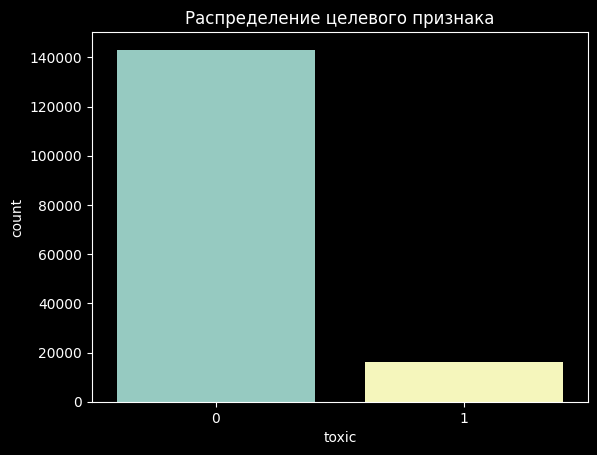

In [6]:
sns.countplot(data=w, x='toxic')
plt.title('Распределение целевого признака');

Мы видим, что в целевом признаке имеется дисбаланс. Текстов, помеченных как токсичные (значение 1 у целевой переменной), — около 10% выборки, нейтральных (со значением 0 в столбце `toxic`) — порядка 90%.

Посмотрим, как выглядят наши тексты.

In [7]:
w.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


В наших текстах есть знаки пунктуации, спецсимволы. Нужно очистить данные от этих символов, а также провести лемматизацию текстов, то есть поставить все слова в их начальную форму. Воспользуемся классом для лемматизации из библиотеки nltk.

In [8]:
lemmatizer = WordNetLemmatizer()

def lemmatize(text):  
    clean_text = re.sub(r'[^a-zA-Z ]', ' ', text)
    return ' '.join([lemmatizer.lemmatize(x) for x in clean_text.split()]) 

In [9]:
w.text =  w.text.apply(lemmatize)

In [10]:
w.text.head()

0    Explanation Why the edits made under my userna...
1    D aww He match this background colour I m seem...
2    Hey man I m really not trying to edit war It s...
3    More I can t make any real suggestion on impro...
4    You sir are my hero Any chance you remember wh...
Name: text, dtype: object

Выделим в данных фичи и таргет и разобьем на обучающую и тестовую выборки с учетом дисбаланса.

In [11]:
features = w.text
target = w.toxic

features_train, features_test, target_train, target_test = (
    train_test_split(features, target, 
                     test_size=.25, 
                     stratify=target, 
                     random_state=88)
)

In [12]:
print(features_train.shape)
print(features_test.shape)
print(target.value_counts(normalize=True))

(119469,)
(39823,)
0    0.898388
1    0.101612
Name: toxic, dtype: float64


Преобразуем признаки в матрицу.

In [13]:
corp_train = features_train.values
corp_test = features_test.values

Далее мы рассчитаем матрицу TF-IDF с учетом стоп-слов и выделим n-граммы (1 и 2 слова). Это мы будем делать в пайплайне, чтобы не было утечки данных.

### Вывод по разделу
Мы провели лемматизацию и подготовили данные к обучению. Разбили данные на тренировочную и тестовую выборки с учетом дисбаланса целевого признака. Далее мы рассчитаем в пайплайне матрицу TF-IDF с учетом стоп-слов и выделим n-граммы. 

## Обучение

Обучим на подготовленных данных модели логистической регрессии и SGDClassifier.

### Логистическая регрессия

In [14]:
stops = list(stopwords.words('english'))

In [15]:
%%time
lrm_params = {'model__C': [7, 9]}

lrm_pipeline = Pipeline([('vect', 
                          TfidfVectorizer(stop_words=stops, 
                                          ngram_range=(1,2))),
                         ('model', 
                          LogisticRegression(random_state=88, 
                                             class_weight='balanced'))])

    
lrm_rs = RandomizedSearchCV(lrm_pipeline, 
                            lrm_params,
                            scoring='f1', 
                            cv=5,
                            random_state=88)

lrm_rs.fit(corp_train, target_train)


CPU times: user 14min 55s, sys: 5min 42s, total: 20min 37s
Wall time: 14min 25s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vect',
                                              TfidfVectorizer(ngram_range=(1,
                                                                           2),
                                                              stop_words=['i',
                                                                          'me',
                                                                          'my',
                                                                          'myself',
                                                                          'we',
                                                                          'our',
                                                                          'ours',
                                                                          'ourselves',
                                                                          'you',
                                                                          "you're",
                                                                          "you've",
                                                                          "you'll",
                                                                          "you'd",
                                                                          'your',
                                                                          'yours',
                                                                          'yourself',
                                                                          'yourselves',
                                                                          'he',
                                                                          'him',
                                                                          'his',
                                                                          'himself',
                                                                          'she',
                                                                          "she's",
                                                                          'her',
                                                                          'hers',
                                                                          'herself',
                                                                          'it',
                                                                          "it's",
                                                                          'its',
                                                                          'itself', ...])),
                                             ('model',
                                              LogisticRegression(class_weight='balanced',
                                                                 random_state=88))]),
                   param_distributions={'model__C': [7, 9]}, random_state=88,
                   scoring='f1')

In [16]:
print(f'Лучшая метрика F1 у модели логистической регрессии: {lrm_rs.best_score_}')

Лучшая метрика F1 у модели логистической регрессии: 0.775621260148031


### SGDClassifier

In [17]:
%%time

sgd_params = {'sgd__loss': ['hinge', 'log'],
             'sgd__n_iter_no_change': [20, 30, 40]}

sgd_pipeline = Pipeline([('vect', TfidfVectorizer(stop_words=stops, 
                                                  ngram_range=(1,2))),
                         ('sgd', SGDClassifier(random_state=88, 
                                               class_weight='balanced'))])

    
sgd_rs = RandomizedSearchCV(sgd_pipeline, 
                            sgd_params,
                            scoring='f1', 
                            cv=5,
                            random_state=88)

sgd_rs.fit(corp_train, target_train)


CPU times: user 13min 50s, sys: 13.7 s, total: 14min 3s
Wall time: 14min


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vect',
                                              TfidfVectorizer(ngram_range=(1,
                                                                           2),
                                                              stop_words=['i',
                                                                          'me',
                                                                          'my',
                                                                          'myself',
                                                                          'we',
                                                                          'our',
                                                                          'ours',
                                                                          'ourselves',
                                                                          'you',
                                                                          "you're",
                                                                          "you've",
                                                                          "you'll",
                                                                          "you'd",
                                                                          'your',
                                                                          'yours',
                                                                          'yourself',
                                                                          'yourselves',
                                                                          'he',
                                                                          'him',
                                                                          'his',
                                                                          'himself',
                                                                          'she',
                                                                          "she's",
                                                                          'her',
                                                                          'hers',
                                                                          'herself',
                                                                          'it',
                                                                          "it's",
                                                                          'its',
                                                                          'itself', ...])),
                                             ('sgd',
                                              SGDClassifier(class_weight='balanced',
                                                            random_state=88))]),
                   param_distributions={'sgd__loss': ['hinge', 'log'],
                                        'sgd__n_iter_no_change': [20, 30, 40]},
                   random_state=88, scoring='f1')

In [18]:
print(f'Лучшая метрика F1 у модели SGDClassifier: {sgd_rs.best_score_}')

Лучшая метрика F1 у модели SGDClassifier: 0.7206893435202298


### Тестирование модели

Лучший результат на обучающих данных показала модель логистической регрессии. Проверим ее на тестовой выборке.

In [19]:
predictions = lrm_rs.predict(corp_test)
print(f'F1 модели логистической регрессии на тестовых данных: {f1_score(target_test, predictions)}')

F1 модели логистической регрессии на тестовых данных: 0.792174858108924


## Выводы

Мы обучили модель логистической регрессии, на тестовых данных она показала значение метрики F1 0.79.